In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import torch
import transformers
import wandb
import generate_plots
import example_groups

from dataloader import DataLoader
from evaluate import load
from trainer import CustomTrainer
from transformers import (
    AutoModelForSequenceClassification,
    TrainingArguments,
    DataCollatorWithPadding
)
from datasets import load_dataset

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

/vol/bitbucket/hrm20/fypenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/vol/bitbucket/hrm20/fypenv/lib/python3.10/site-packages/transformers/utils/hub.py:128: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


In [2]:
torch.cuda.empty_cache()

# Load Dataset

In [3]:
os.environ["WANDB_MODE"] = "disabled"  # Disable wandb logging
os.environ["WANDB_DISABLED"] = "true"  # Fully disable wandb

# # os.environ["WANDB_MODE"] = "enabled"  # Enable wandb logging
# os.environ["WANDB_ENABLED"] = "true"  # Fully enable wandb

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model_name = "google-bert/bert-base-uncased"
dataset_name = "multi_nli"

data_loader = DataLoader(dataset_name, model_name)
train_dataset, eval_dataset, tokenizer, num_labels = data_loader.prepare_datasets()

Using device: cuda


# Train

In [4]:
# from transformers import AdamW

# # Define optimizer explicitly
# optimizer = AdamW(
#     model.parameters(), 
#     lr=2e-5,  # Match the paper
#     betas=(0.9, 0.999),  # Standard AdamW betas
#     eps=1e-8,  # Prevents division by zero
#     weight_decay=0.01  # Matches the paper
# )

In [5]:
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=num_labels  # MNLI has 3 classes: entailment, contradiction, neutral
)
model.to(device)

# Load accuracy metric
metric = load("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels)

# Training arguments
training_args = TrainingArguments(
    output_dir="bert-base-mnli",
    learning_rate=1e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=2,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    # load_best_model_at_end=True,
    # push_to_hub=False,
    # logging_steps=500,
    # logging_first_step=True,
    fp16=True
)


wandb.init(
    project="bert_base_mnli",
    name=f"{training_args.num_train_epochs}_epochs_{dataset_name}_bert_base",
    config=training_args.to_dict(),
)

# Initialise trainer and train
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
    data_collator=DataCollatorWithPadding(tokenizer=tokenizer),
    compute_metrics=compute_metrics,
    methods=["loss", "forgetting", "el2n", "grand"],
    # optimizers=(optimizer, None),
    device=device,
)

trainer.train()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/vol/bitbucket/hrm20/fypenv/lib/python3.10/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/vol/bitbucket/hrm20/fyp/trainer.py:9: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Epoch,Training Loss,Validation Loss,Accuracy
1,0.473000,0.466753,0.824147
2,0.405600,0.444333,0.834947


TrainOutput(global_step=24544, training_loss=0.4793068716081522, metrics={'train_runtime': 4194.0903, 'train_samples_per_second': 187.264, 'train_steps_per_second': 5.852, 'total_flos': 1.4152489944584166e+17, 'train_loss': 0.4793068716081522, 'epoch': 2.0})

# Analysis

In [6]:
forgetting_results = trainer.get_unified_stats()['forgetting_stats']['forgetting_events']
epoch_losses = trainer.get_unified_stats()['loss_stats']['epoch_losses']
per_sample_losses = trainer.get_unified_stats()['loss_stats']['per_sample_losses']
all_losses = trainer.get_unified_stats()['loss_stats']['all_losses']
# data_map_stats = trainer.get_unified_stats()["data_map_stats"]
# aum_scores = trainer.get_unified_stats()["aum_stats"]['aum_scores']
# sample_margins = trainer.get_unified_stats()["aum_stats"]['sample_margins']


predictions = trainer.get_unified_stats()['predictions']
true_labels = trainer.get_unified_stats()['true_labels']

total_samples = len(train_dataset)

In [13]:
grand_scores = trainer.get_unified_stats()['grand_scores']
el2n_scores = trainer.get_unified_stats()['el2n_scores']
mnli = load_dataset('multi_nli')
results = example_groups.get_example_group_results(mnli)

In [8]:
print(results['Contradiction with High Word Overlap'][:10])
results['Entailment with High Word Overlap'][:10]

[46, 47, 58, 392, 428, 435, 718, 753, 896, 906]


[24, 35, 50, 85, 87, 94, 111, 115, 129, 168]

In [9]:
# all_losses[1][718]
# print(all_losses[0][44])
print(all_losses[0][34])
print(all_losses[0][35])
print(all_losses[0][36])
# print(np.mean(grand_scores, axis=1))
# print(np.mean(el2n_scores, axis=1))

0.35195913910865784
0.20405147969722748
1.0648353099822998


In [10]:
for idx, (group, indices) in enumerate(results.items()):
    if not indices:
        print(f"No examples in the group {group}.")
        continue

    group_losses = all_losses[:, indices]
    avg_loss_per_epoch = np.mean(group_losses, axis=0)
    print(avg_loss_per_epoch[100:110])

TypeError: list indices must be integers or slices, not tuple

[5.67961672 3.5209591 ]
[2.15719869 1.2621316 ]


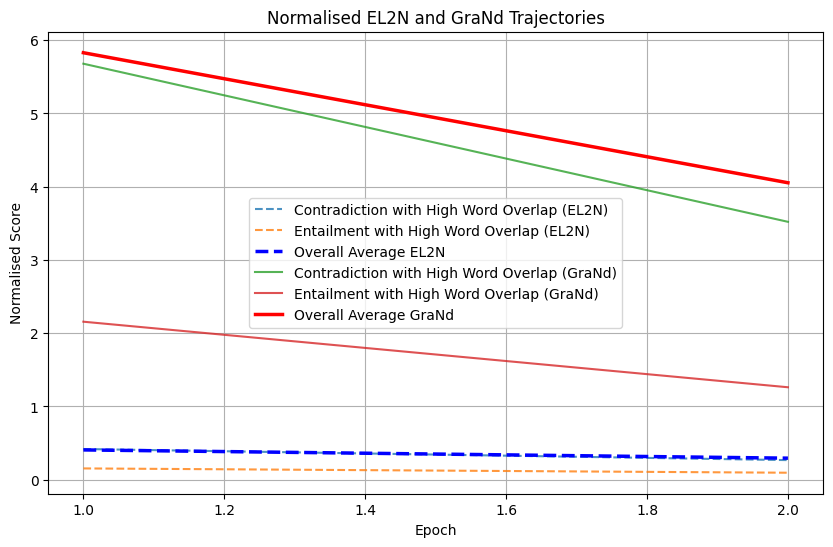

In [15]:
def min_max_normalize(scores):
    min_val = np.nanmin(scores)
    max_val = np.nanmax(scores)
    if max_val - min_val != 0:
        return (scores - min_val) / (max_val - min_val)
    else:
        return np.zeros_like(scores)

normalized_el2n = min_max_normalize(el2n_scores)
normalized_grand = min_max_normalize(grand_scores)

normalized_el2n = el2n_scores
normalized_grand = grand_scores


fig, ax = plt.subplots(figsize=(10, 6))

# Plot EL2N scores
for idx, (group, indices) in enumerate(results.items()):
    if not indices:
        continue

    # EL2N Scores
    group_el2n = normalized_el2n[:, indices]
    avg_el2n_per_epoch = np.nanmean(group_el2n, axis=1)

    ax.plot(range(1, len(avg_el2n_per_epoch) + 1),
            avg_el2n_per_epoch,
            label=f"{group} (EL2N)",
            linestyle='--',  # Dashed lines for EL2N
            alpha=0.8)

# Overall EL2N Average
overall_avg_el2n = np.nanmean(normalized_el2n, axis=1)
ax.plot(range(1, len(overall_avg_el2n) + 1),
        overall_avg_el2n,
        label='Overall Average EL2N',
        linestyle='--',
        linewidth=2.5,
        color='blue')

# Plot GraNd scores
for idx, (group, indices) in enumerate(results.items()):
    if not indices:
        continue

    # GraNd Scores
    group_grand = normalized_grand[:, indices]
    avg_grand_per_epoch = np.nanmean(group_grand, axis=1)

    ax.plot(range(1, len(avg_grand_per_epoch) + 1),
            avg_grand_per_epoch,
            label=f"{group} (GraNd)",
            linestyle='-',  # Solid lines for GraNd
            alpha=0.8)

    print(avg_grand_per_epoch)

# Overall GraNd Average
overall_avg_grand = np.nanmean(normalized_grand, axis=1)
ax.plot(range(1, len(overall_avg_grand) + 1),
        overall_avg_grand,
        label='Overall Average GraNd',
        linestyle='-',
        linewidth=2.5,
        color='red')

# Graph Titles and Labels
ax.set_title("Normalised EL2N and GraNd Trajectories")
ax.set_xlabel("Epoch")
ax.set_ylabel("Normalised Score")
ax.legend()
ax.grid(True)

plt.show()

In [ ]:
plt.savefig("normalised_el2n_grand.png")
wandb.log({"Normalised EL2N and GraNd Trajectories": wandb.Image("normalised_el2n_grand.png")})

<Figure size 640x480 with 0 Axes>

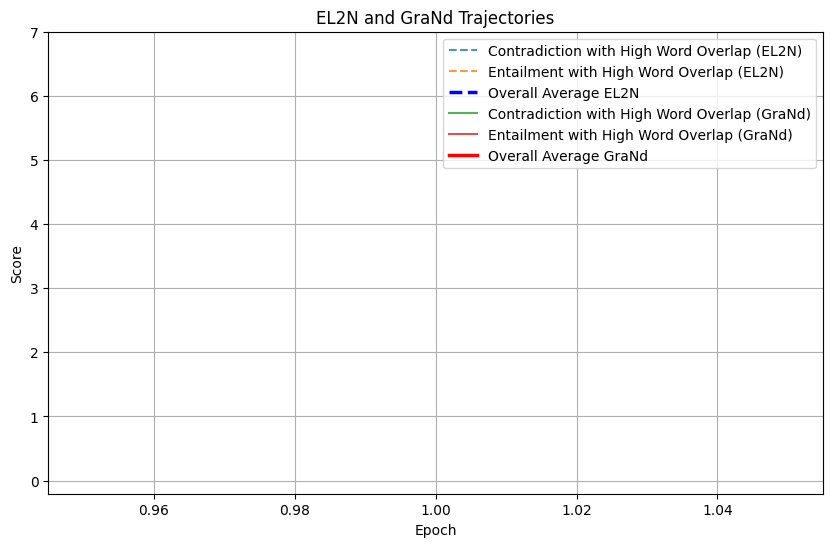

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))

# Plot EL2N scores
for idx, (group, indices) in enumerate(results.items()):
    if not indices:
        continue

    # EL2N Scores
    group_el2n = el2n_scores[:, indices]
    avg_el2n_per_epoch = np.nanmean(group_el2n, axis=1)

    ax.plot(range(1, len(avg_el2n_per_epoch) + 1),
            avg_el2n_per_epoch,
            label=f"{group} (EL2N)",
            linestyle='--',  # Dashed lines for EL2N
            alpha=0.8)

# Overall EL2N Average
overall_avg_el2n = np.nanmean(el2n_scores, axis=1)
ax.plot(range(1, len(overall_avg_el2n) + 1),
        overall_avg_el2n,
        label='Overall Average EL2N',
        linestyle='--',
        linewidth=2.5,
        color='blue')

# Plot GraNd scores
for idx, (group, indices) in enumerate(results.items()):
    if not indices:
        continue

    # GraNd Scores
    group_grand = grand_scores[:, indices]
    avg_grand_per_epoch = np.nanmean(group_grand, axis=1)

    ax.plot(range(1, len(avg_grand_per_epoch) + 1),
            avg_grand_per_epoch,
            label=f"{group} (GraNd)",
            linestyle='-',  # Solid lines for GraNd
            alpha=0.8)

# Overall GraNd Average
overall_avg_grand = np.nanmean(grand_scores, axis=1)
ax.plot(range(1, len(overall_avg_grand) + 1),
        overall_avg_grand,
        label='Overall Average GraNd',
        linestyle='-',
        linewidth=2.5,
        color='red')

# Graph Titles and Labels
ax.set_title("EL2N and GraNd Trajectories")
ax.set_xlabel("Epoch")
ax.set_ylabel("Score")
ax.legend()
ax.grid(True)

plt.show()

In [ ]:
plt.savefig("el2n_grand.png")
wandb.log({"EL2N and GraNd Trajectories": wandb.Image("el2n_grand.png")})

<Figure size 640x480 with 0 Axes>

## Forgetting

In [ ]:
plt = generate_plots.plot_forgetting_events(forgetting_results=forgetting_results, total_samples=total_samples)
plt.savefig("forgetting_events.png")
wandb.log({"Forgetting Events Chart": wandb.Image("forgetting_events.png")})

plt.tight_layout()
plt.show()

## Losses

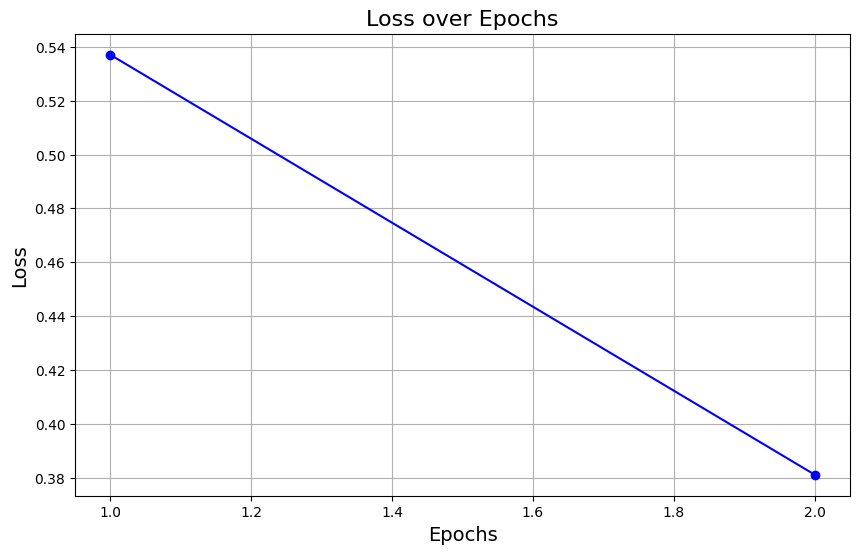

In [ ]:
plt = generate_plots.plot_average_loss_over_epochs(epoch_losses)
plt.savefig("loss_over_epochs.png")
wandb.log({"Loss over Epochs": wandb.Image("loss_over_epochs.png")})
plt.show()

## Example Groups

In [ ]:
len(true_labels)

392702

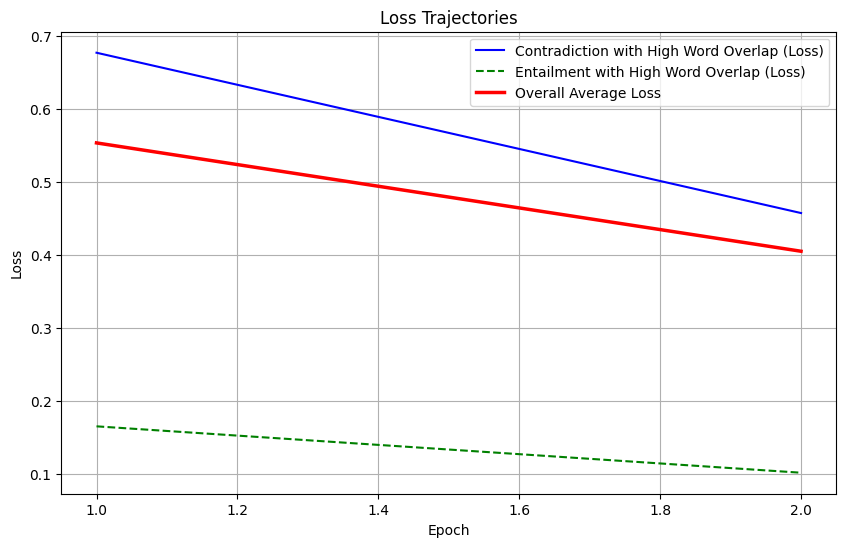

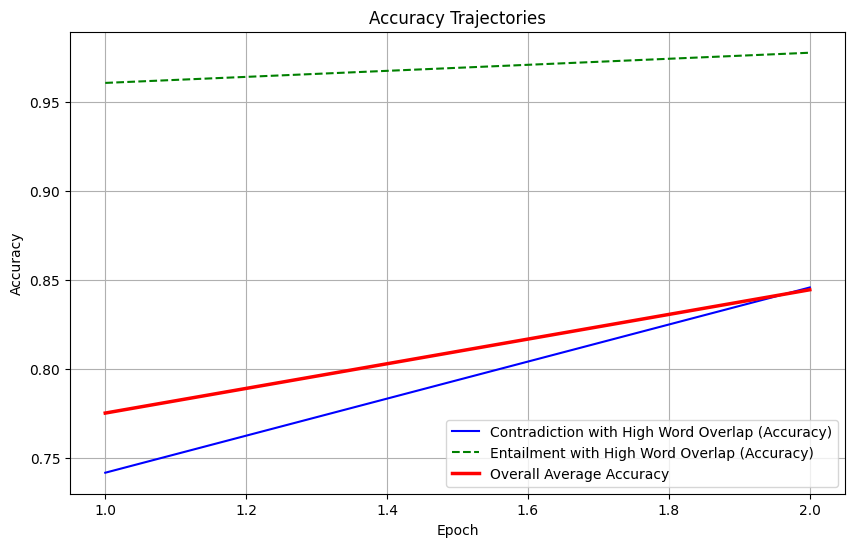

In [12]:
mnli = load_dataset('multi_nli')
fig1, fig2 = generate_plots.plot_losses_and_accuracies(mnli, all_losses, true_labels, predictions)
fig1.show()
fig2.show()

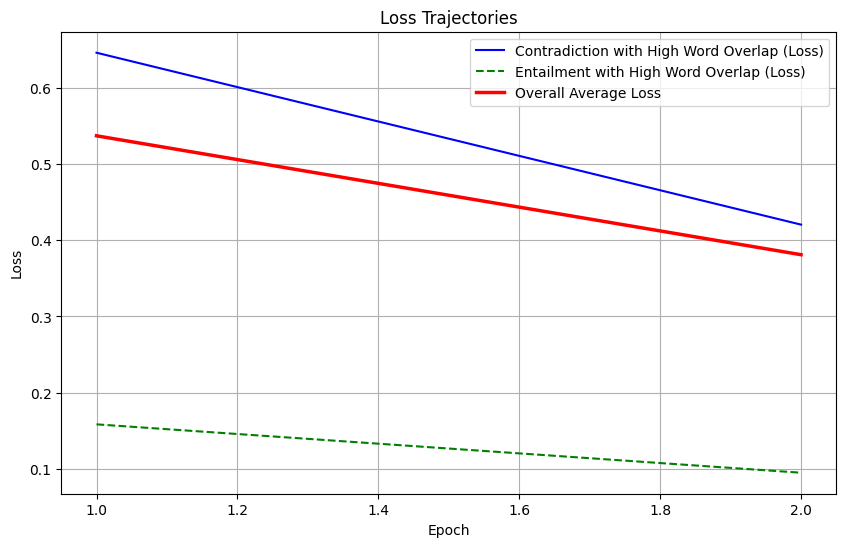

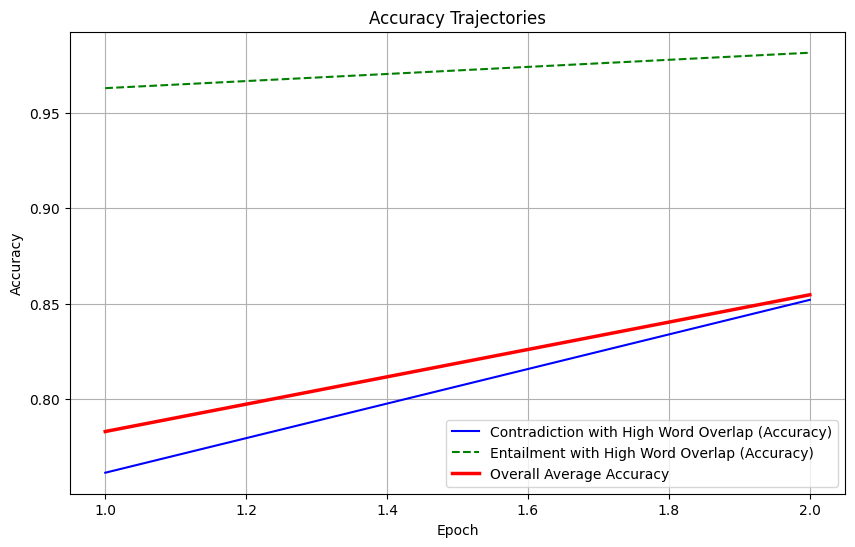

In [ ]:

all_losses = np.array(all_losses)
all_losses = np.nan_to_num(all_losses, nan=0.0)

# Track the accuracies for all epochs
all_accuracies = []
for epoch in range(len(predictions)):
    epoch_accuracy = (np.array(predictions[epoch]) == np.array(true_labels)).astype(float)
    all_accuracies.append(epoch_accuracy)
all_accuracies = np.array(all_accuracies)
all_accuracies = np.nan_to_num(all_accuracies, nan=0.0)

line_styles = ['-', '--', '-.']
colors = ['b', 'g', 'r']

# Figure 1: Losses
fig1, ax1 = plt.subplots(figsize=(10, 6))
for idx, (group, indices) in enumerate(results.items()):
    if not indices:
        print(f"No examples in the group {group}.")
        continue

    group_losses = all_losses[:, indices]
    avg_loss_per_epoch = np.nanmean(group_losses, axis=1)

    ax1.plot(range(1, len(avg_loss_per_epoch) + 1), 
                avg_loss_per_epoch,
                label=f"{group} (Loss)",
                linestyle=line_styles[idx % len(line_styles)],
                color=colors[idx % len(colors)])

overall_avg_loss_per_epoch = np.nanmean(all_losses, axis=1)
ax1.plot(range(1, len(overall_avg_loss_per_epoch) + 1), 
            overall_avg_loss_per_epoch,
            label='Overall Average Loss',
            linestyle='-',
            color=colors[-1],
            linewidth=2.5)
ax1.set_title("Loss Trajectories")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.legend()
ax1.grid(True)

# Figure 2: Accuracies
fig2, ax2 = plt.subplots(figsize=(10, 6))
for idx, (group, indices) in enumerate(results.items()):
    if not indices:
        continue
    group_accuracies = all_accuracies[:, indices]
    avg_accuracy_per_epoch = np.mean(group_accuracies, axis=1)

    ax2.plot(range(1, len(avg_accuracy_per_epoch) + 1), 
                avg_accuracy_per_epoch,
                label=f"{group} (Accuracy)",
                linestyle=line_styles[idx % len(line_styles)],
                color=colors[idx % len(colors)])

overall_avg_accuracy_per_epoch = np.nanmean(all_accuracies, axis=1)
ax2.plot(range(1, len(overall_avg_accuracy_per_epoch) + 1),
            overall_avg_accuracy_per_epoch,
            label='Overall Average Accuracy',
            linestyle='-',
            color=colors[-1],
            linewidth=2.5)
ax2.set_title("Accuracy Trajectories")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Accuracy")
ax2.legend()
ax2.grid(True)


In [ ]:
fig1.savefig("group_loss_trajectories.png")
fig2.savefig("group_accuracy_trajectories.png")
wandb.log({"Loss Trajectories for High Word Overlap Groups": wandb.Image("group_loss_trajectories.png")})
wandb.log({"Accuracy Trajectories for High Word Overlap Groups": wandb.Image("group_accuracy_trajectories.png")})

## Data Maps

In [ ]:
# fig1, fig2 = generate_plots.plot_data_map(data_map_stats)
# fig1.show()
# fig2.show()
# fig1.savefig("data_map.png")
# fig2.savefig("data_map_variables.png")
# wandb.log({"Data Map: Variability vs Confidence": wandb.Image("data_map.png")})
# wandb.log({"Confidence, Correctness and Variability": wandb.Image("data_map_variables.png")})

In [ ]:
# def plot_data_map(data_map_stats):
#     confidence = np.array(data_map_stats["confidence"][:2500])
#     variability = np.array(data_map_stats["variability"][:2500])
#     correctness = np.array(data_map_stats["correctness"][:2500])

#     # --- First Figure: Scatter Plot ---
#     fig1, ax1 = plt.subplots(figsize=(8, 6))
#     scatter = ax1.scatter(variability, confidence, c=correctness, cmap="coolwarm", alpha=0.6, edgecolors="k")
#     ax1.set_xlabel("Variability")
#     ax1.set_ylabel("Average Confidence")
#     ax1.set_ylim(0, 1.1)
#     ax1.set_title("Data Map: Variability vs. Confidence")
#     fig1.colorbar(scatter, ax=ax1, label="Correctness")
#     ax1.grid(True, linestyle="--", alpha=0.5)
#     return fig1
# fig = plot_data_map(data_map_stats)
# fig.show()
# fig.savefig("data_map_2k_examples.png")
# wandb.log({"Smaller Data Map: Variability vs Confidence": wandb.Image("data_map_2k_examples.png")})

## AUM

In [ ]:
# plt = generate_plots.plot_aum(sample_margins, true_labels, predictions)
# plt.show()
# plt.savefig("aum_labeled_vs_mislabeled.png")
# wandb.log({"AUM Trajectories for Labeled and Mislabeled Examples": wandb.Image("aum_labeled_vs_mislabeled.png")})

In [ ]:
wandb.log({
    "epoch_losses": epoch_losses,
    "per_sample_losses": per_sample_losses,
    # "final_forgetting_stats": forgetting_results,
    "all_losses": all_losses,
    "grand_scores": grand_scores,
    "el2n_scores": el2n_scores,
    # "data_map_stats": data_map_stats,
    # "sample_margins": sample_margins,
    "predictions": predictions
})

wandb: WARNING Serializing object of type ndarray that is 3141744 bytes
wandb: WARNING Serializing object of type ndarray that is 3141744 bytes


In [ ]:
wandb.finish()

eval/accuracy,▁
eval/loss,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
train/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇███████
train/grad_norm,▄▄▅▄▂▃▄▆█▇▃▅▃▅▃▆▄▃▂▅▆▄▃▃▃▄▆▆▆▄▆█▄▄▃▃▃▁▃▃
train/learning_rate,████▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁
train/loss,█▅▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval/accuracy,0.84035
